In [43]:

%matplotlib inline
import torch 
import torchvision
from IPython import display
from d2l import torch as d2l
from torch.utils import data
from torchvision import transforms

In [44]:
def get_dataloader_workers():
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
    num_workers=get_dataloader_workers()),
    data.DataLoader(mnist_test, batch_size, shuffle=False,
    num_workers=get_dataloader_workers()))

In [45]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)


num_input=784
num_output = 10


w = torch.normal(0,0.01, (num_input, num_output), requires_grad=True)
b = torch.zeros(num_output, requires_grad=True)

In [46]:
def softmax(X):
    X_exp =torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp/partition 

In [56]:
## define model

def net(X):
    return softmax(X.reshape((-1, w.shape[0]))@w+ b)

In [57]:

# label, 
y = torch.tensor([0,2])
# predictions, we have 3 cats and 2 predictions results for two requests
y_hat = torch.tensor([[0.1, 0.3,0.6], [0.3,0.2, 0.5]])


# [[0,1], [0,2]]--> [[0,0],[1,2]], 1st element is [0,1], 2nd element is [1,2]
y_hat[[0,1], y]

tensor([0.1000, 0.5000])

In [49]:
y_hat[[0,1], 1]

tensor([0.3000, 0.2000])

In [50]:

# _hat means predictions, y means real value, like label
#  range(len(y_hat)) means how many items(rows), y is label
# so it will return y_hat predictions for each class
# range(len(y_hat)) -> range(row_size_of_y_hat)--> range(2)-> [0,1]
# y_hat[[0,2], [0,2]]--> two elements from 2 rows in y_hat, [0,0] and [1,2]

def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])


#  this is just calc only 2 requests loss function
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [61]:
y_hat[range(len(y_hat))]

tensor([[0.1000, 0.3000, 0.6000],
        [0.3000, 0.2000, 0.5000]])

In [54]:
y_hat[range(len(y_hat)), y]

tensor([0.1000, 0.5000])

In [74]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        #  torch.tensor([[0.1, 0.3,0.6], [0.3,0.2, 0.5]])
        # y_hat.argmax(axis=1) → [2, 2]， real y = [0,2]
        y_hat = y_hat.argmax(axis =1)
    #  reset y_hat data type to be same as y, and compare each element whether they are the same or not
    cmp = y_hat.type(y.dtype) == y
    #  this will return 1
    return float(cmp.type(y.dtype).sum())



accuracy(y_hat, y)/len(y), accuracy(y_hat, y)

(0.5, 1.0)

In [63]:

#  data[0] = 存储正确预测的数量 
#  sdata[1] = 预测的总数量
class Accumulator:
    def __init__(self, n):
        
        # [0,0] * n --> repeat [0,0] n times, for example
        # [0,0] * 2 -> [0,0,0,0]
        self.data = [0,0] * n
    
    def add(self, *args):
        #  如果 self.data = [1.0, 2.0, 3.0]，args = (4, 5, 6)，那么：
        # zip(self.data, args) ➜ [(1.0, 4), (2.0, 5), (3.0, 6)]
        self.data =[a+float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0]* len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    

In [72]:

def evaluate_accuracy(net, data_iter):
    # here we just call manual softmax one, not pytorch one
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            # accuracy(net(X), y)--> return one value, [1,0]
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0]/metric[1]

In [73]:
evaluate_accuracy(net, test_iter)

0.085

In [75]:
#  train code
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    
    return metric[0]/metric[2], metric[1]/metric[2]

In [77]:
#draw the graph
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend =None, xlim=None, 
                 ylim = None, xscale='linear', yscale='linear', fmts=('-', 'm--', 'g-', 'r:'), 
                 nrows =1, ncols=1, figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
    

In [78]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
    legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [79]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

NameError: name 'W' is not defined

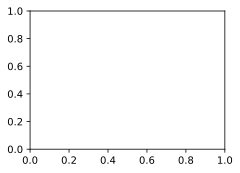

In [80]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)